# Downloading, Aggregating and Formatting Benchmark Datasets (Traffic & Electricity)

- **Author**: Andrés Carrillo López
- **Thesis Tutor**: Pablo Martínez Olmos
- **Master Thesis**: *'Time Series Forecasting using Transformers'*
- **Goal of this notebook**: Identifying the benchmark datasets used in the literature for experiments with Transformers for time series forecasting tasks. Retrieve datasets and aggregate and format them using the 'Google Research' repository module for reproducibility of the used dataset. Once the datasets have been retrieved, aggregated and formatted as in Google's experiments, instead of using their implemented TFT, the data will be then processed for the Pytorch-Forecasting library 'TimeSeriesDataset' format.

## Intro / Context

As the repository from Google Research paper titled "[From Temporal Fusion Transformer paper](https://arxiv.org/pdf/1912.09363v3.pdf)" has been used for data extraction and aggregation, the following relevant excerpts from the mentioned papers have been issued:

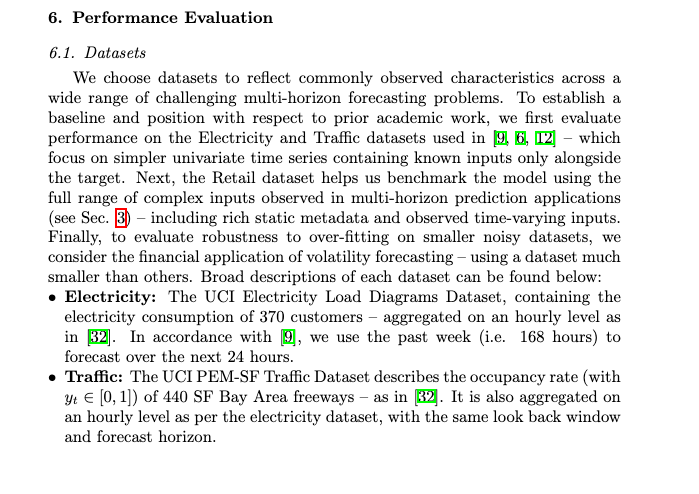

From DeepAR paper (reference [9] in Google TFT paper from above):
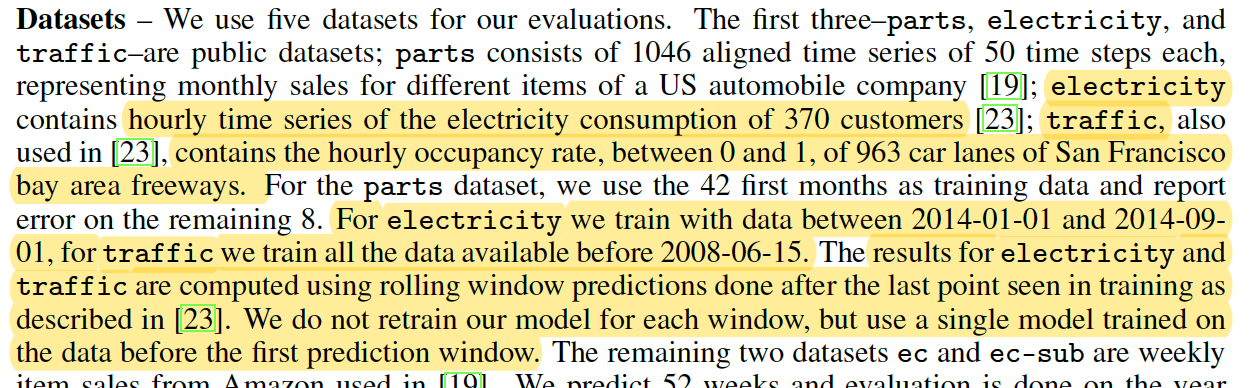

From the reference [32] ([Temporal Regularized Matrix Factorization forHigh-dimensional Time Series Prediction](https://papers.nips.cc/paper/2016/hash/85422afb467e9456013a2a51d4dff702-Abstract.html) in Google TFT paper ):

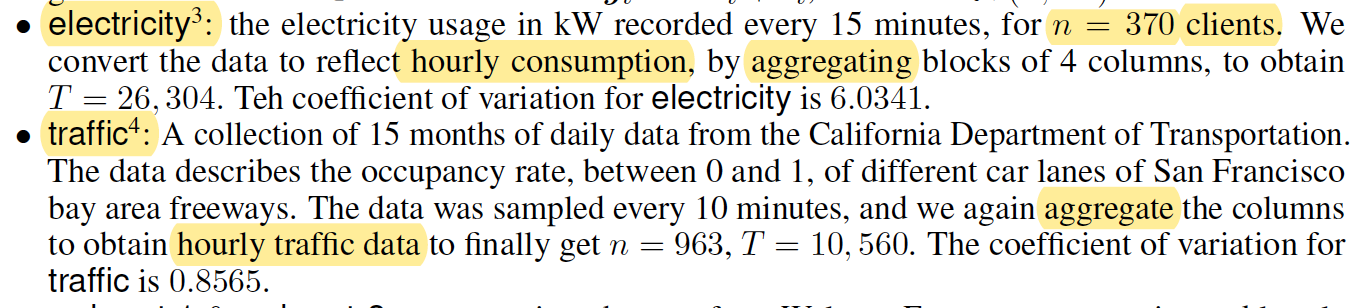

## Setup

In [1]:
import pandas as pd

- Electricity Dataset: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

- Traffic Dataset: https://archive.ics.uci.edu/ml/datasets/PEMS-SF

In [2]:
# Note: my Google Drive has been synced with this colab notebook previously
%cd "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks"
!ls

/content/drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks
 data		    Pytorch-Forecasting
 __MACOSX	   '[TFM] Adapting dataset to TimeSeriesDataset format.ipynb'
'Pruebas   Otros'   tft


In [3]:
# I have created two empty folders for hosting the datasets (traffic and electr)
!ls data/

 electr  'Raw data'   traffic


Note: [Google's Research Repository](https://github.com/google-research/google-research/tree/master/tft) has a TemporalFusionTransformer implementation library that has a useful preprocessing code for the benchmark datasets.

#### Cloning Google-Research Repo (I have only executed this code's section for the first time)

In [ ]:
# For cloning a specific subfolder, better use subversion (git cannot)
!apt install subversion
!svn export https://github.com/google-research/google-research/trunk/tft

In [9]:
# check that the "tft" folder has been added to the tfm drive folder
!ls

 data		    Pytorch-Forecasting
 __MACOSX	   '[TFM] Adapting dataset to TimeSeriesDataset format.ipynb'
'Pruebas   Otros'   tft


In [12]:
# I need to import the files as a library from my foldrs
!touch tft/__init__.py

#### Importing the GoogleResearch' TFT processing library

In [6]:
%cd tft

/content/drive/My Drive/Máster Big Data (2020-2021)/TFM/Code Notebooks/tft


In [7]:
# Checking the Google's repo
!ls

data_formatters  __pycache__	   script_download_data.py
expt_settings	 README.md	   script_hyperparam_opt.py
__init__.py	 requirements.txt  script_train_fixed_params.py
libs		 run.sh


In [ ]:
# Making sure all needed libraries and exact versions are matched
!pip install -r requirements.txt

In [9]:
# importing the two relevant processing scripts
from tft.data_formatters import electricity, traffic

In [4]:
from tft.libs import utils
import tft
dir(tft)

The *data_formatters* modules allow for several data formatting functions required for conducting the experiments. According to its [repo](https://github.com/google-research/google-research/blob/master/tft/data_formatters/base.py), the different formatters include functions capable of:

> 1) Define the column and input types for tabular dataframes used by model

> 2) Perform the necessary input feature engineering & normalisation steps

> 3) Reverts the normalisation for predictions

> 4) Are responsible for train, validation and test splits

## Electricity Dataset

More info about this dataset (raw version from UCI-ML): https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

In [10]:
!ls

data_formatters  __pycache__	   script_download_data.py
expt_settings	 README.md	   script_hyperparam_opt.py
__init__.py	 requirements.txt  script_train_fixed_params.py
libs		 run.sh


### Downloading and aggregating (hourly) data

This script (provided in Google repo) downloads the dataset from the UCI ML data repository and performs hourly aggregation.

In [ ]:
# (ommited long output)
!python3 script_download_data.py electricity electr/

It has created a new folder named 'electr' containing the formated data and some other folders. I will only use the relevant files, so:

In [18]:
!ls electr/data/electricity
# (LD2011_2014.txt is the original UCI ML non-aggregated raw data)

hourly_electricity.csv	LD2011_2014.txt  LD2011_2014.txt.zip  __MACOSX


In [24]:
# I will move the 'hourly_electricity.csv' file to the empty folder previously created 
!ls ../data/

 electr  'Raw data'   traffic


In [25]:
!mv electr/data/electricity/hourly_electricity.csv ../data/electr/
!ls ../data/electr/

hourly_electricity.csv


Taking a look now at the hourly aggregated Electricity data:

In [33]:
electr_df_hourly = pd.read_csv("../data/electr/hourly_electricity.csv", index_col=0)
electr_df_hourly

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,2.538071,26304.0,1096,MT_001,2014-01-01 00:00:00,MT_001,0,1,2,1,26304.0,2,0
17545,2.855330,26305.0,1096,MT_001,2014-01-01 01:00:00,MT_001,1,1,2,1,26305.0,2,1
17546,2.855330,26306.0,1096,MT_001,2014-01-01 02:00:00,MT_001,2,1,2,1,26306.0,2,2
17547,2.855330,26307.0,1096,MT_001,2014-01-01 03:00:00,MT_001,3,1,2,1,26307.0,2,3
17548,2.538071,26308.0,1096,MT_001,2014-01-01 04:00:00,MT_001,4,1,2,1,26308.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10461482,20824.324324,32299.0,1345,MT_370,2014-09-07 19:00:00,MT_370,19,7,6,9,32299.0,6,19
10461483,19527.027027,32300.0,1345,MT_370,2014-09-07 20:00:00,MT_370,20,7,6,9,32300.0,6,20
10461484,20202.702703,32301.0,1345,MT_370,2014-09-07 21:00:00,MT_370,21,7,6,9,32301.0,6,21
10461485,19851.351351,32302.0,1345,MT_370,2014-09-07 22:00:00,MT_370,22,7,6,9,32302.0,6,22


### Formatting the data

For more details, [tft/data_formatters/electricity.py](https://github.com/google-research/google-research/blob/b98dcf3a272cb69cfaf7f68624e92db2e03dbc52/tft/data_formatters/electricity.py)

In [34]:
# In Google's repo they instantiate first a datasetFormatter() and then they
#   perform several dataset-specific implemented functions
dataform_electr = electricity.ElectricityFormatter()

# Train-Validation-Test Sets Splitting
train, valid, test = dataform_electr.split_data(electr_df_hourly)

Formatting train-valid-test splits.
Setting scalers with training data...


Note that the attributes *power_usage*, *hour*, *day_of_week* and *hours_from_start* have been **scaled**.

In [39]:
train.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,-0.127174,26304.0,1096,0,2014-01-01 00:00:00,MT_001,-1.661325,1,-0.499719,1,-1.731721,2,0
17545,-0.050713,26305.0,1096,0,2014-01-01 01:00:00,MT_001,-1.516862,1,-0.499719,1,-1.731062,2,1
17546,-0.050713,26306.0,1096,0,2014-01-01 02:00:00,MT_001,-1.372399,1,-0.499719,1,-1.730403,2,2
17547,-0.050713,26307.0,1096,0,2014-01-01 03:00:00,MT_001,-1.227936,1,-0.499719,1,-1.729744,2,3
17548,-0.127174,26308.0,1096,0,2014-01-01 04:00:00,MT_001,-1.083473,1,-0.499719,1,-1.729085,2,4


In [41]:
train['date'].min(), train['date'].max()
# Train using up to August 7th data

('2014-01-01 00:00:00', '2014-08-07 23:00:00')

In [42]:
valid.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
22632,2.472526,31392.0,1308,0,2014-08-01 00:00:00,MT_001,-1.661325,1,0.504303,8,1.621656,4,0
22633,3.313606,31393.0,1308,0,2014-08-01 01:00:00,MT_001,-1.516862,1,0.504303,8,1.622315,4,1
22634,3.313606,31394.0,1308,0,2014-08-01 02:00:00,MT_001,-1.372399,1,0.504303,8,1.622974,4,2
22635,3.390068,31395.0,1308,0,2014-08-01 03:00:00,MT_001,-1.227936,1,0.504303,8,1.623633,4,3
22636,3.313606,31396.0,1308,0,2014-08-01 04:00:00,MT_001,-1.083473,1,0.504303,8,1.624292,4,4


In [43]:
valid['date'].min(), valid['date'].max()
# Validates using up to August 31st data, starting 1 week prior the last training sample
# Note: probably those 'repeated' 7 days will only be used for the Encoder init. (?)
# this accords to the paper indications: 
#       "we use the  past  week  (i.e. 168  hours)  to forecast over the next 24 hours"
# hence, to forecast the first 24hrs of the test data (not incl. in train), the prior
#  week (also the last week of training data) must be used for inference

('2014-08-01 00:00:00', '2014-08-31 23:00:00')

In [44]:
test.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
23208,3.313606,31968.0,1332,0,2014-08-25 00:00:00,MT_001,-1.661325,25,-1.503741,8,2.001283,0,0
23209,3.160683,31969.0,1332,0,2014-08-25 01:00:00,MT_001,-1.516862,25,-1.503741,8,2.001942,0,1
23210,3.160683,31970.0,1332,0,2014-08-25 02:00:00,MT_001,-1.372399,25,-1.503741,8,2.002601,0,2
23211,3.313606,31971.0,1332,0,2014-08-25 03:00:00,MT_001,-1.227936,25,-1.503741,8,2.003260,0,3
23212,3.237144,31972.0,1332,0,2014-08-25 04:00:00,MT_001,-1.083473,25,-1.503741,8,2.003920,0,4


In [45]:
test['date'].min(), test['date'].max()
# Tests using up to Sept 7 data, starting 7 days prior the last VALIDATION sample

('2014-08-25 00:00:00', '2014-09-07 23:00:00')

In [48]:
# "Gets the default number of training and validation samples.
#  Use to sub-sample the data for network calibration and a value of -1 uses all available samples"
train_samples, valid_samples = dataform_electr.get_num_samples_for_calibration()
train_samples, valid_samples
# I have noticed that those values are only used for 'network calibration' prior to training. 
# Network callibration is just for sanitizing/initializing the network as a 'warm start' (I think)
# ---> Hence, not using them for the moment <---

(450000, 50000)

In [51]:
train.shape[0],valid.shape[0],test.shape[0]

(1923536, 274536, 123984)

In [ ]:
# TODO: Review code from processing in 
#     - https://github.com/google-research/google-research/blob/master/tft/script_train_fixed_params.py 
#     - https://github.com/google-research/google-research/blob/b98dcf3a272cb69cfaf7f68624e92db2e03dbc52/tft/libs/tft_model.py#L1101
# (i.e. data proc. prior to model fitting) and note which attributes are feeded into the model as predictors

### TimeSeriesDataset Creation (Pytorch-Forecasting Compatibility)

TODO: 
- Check [Pytorch-Forecasting Docs on Dataset Building](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/building.html#Passing-data-to-a-model)
- [TimeSeriesDataset](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet)

In [ ]:
# TODO: Adapt formatted dataset (as GoogleTFT impl.) to be used with PytorchForecasting module

## Traffic Dataset

More info about this dataset (raw version from UCI-ML): https://archive.ics.uci.edu/ml/datasets/PEMS-SF

### Download and aggregating (hourly) data

This script (provided in Google repo) downloads the dataset from the UCI ML data repository and performs hourly aggregation.

In [26]:
# (Recall where are we in the file system)
!pwd

/content/drive/My Drive/Máster Big Data (2020-2021)/TFM/Code Notebooks/tft


In [ ]:
# Same drill as before, but with the traffic dataset.
# (omitted long output)
!python3 script_download_data.py traffic traffic/

It has created a new folder named 'traffic' containing the formated data and some other folders. Again, I will only use the relevant files, so:

In [29]:
!ls traffic/data/traffic
# (PEMS-SF.zip is the original UCI ML non-aggregated raw data)

hourly_data.csv  PEMS_test	  PEMS_train	    randperm
PEMS-SF.zip	 PEMS_testlabels  PEMS_trainlabels  stations_list


In [31]:
# I will move the 'hourly_data.csv' file to the empty folder previously created 
!ls ../data/

 electr  'Raw data'   traffic


In [32]:
!mv traffic/data/traffic/hourly_data.csv ../data/traffic/
!ls ../data/traffic/

hourly_data.csv


### Formatting the data

In [ ]:
#TODO

### TimeSeriesDataset Creation (Pytorch-Forecasting Compatibility)

In [ ]:
# TODO